In [1]:
import numpy as np
import pyaudio
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift, ifft, ifftshift

In [2]:
sample_rate, audio = wavfile.read("Ed Sheeran - Perfect (Official Music Video).wav")
#sample_rate, audio = wavfile.read("sarigamapa.wav")

In [3]:
input_array = np.array(audio[0*sample_rate:17*sample_rate, 0])
print(input_array.dtype)
# Create an interface to PortAudio
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16,
                channels = 1,
                rate = sample_rate,
                output = True)

stream.write(input_array.tobytes()) 

# Close and terminate the stream
stream.stop_stream()
stream.close()
p.terminate()

int16


In [4]:
def scale_array(input_array, output_array):
    #input
    input_max_size = 2**((input_array.dtype.itemsize)*8 - 1)
    input_max = np.max(input_array)
    input_ratio = input_max / input_max_size
    #output
    output_max_size = 2**((output_array.dtype.itemsize)*8 - 1)
    output_max = np.max(output_array)
    output_ratio = output_max / output_max_size
    #scaling
    scaling_factor = int(input_ratio/output_ratio)
    return output_array*scaling_factor

In [5]:
frequency_shift = 10   #in hertz
f = frequency_shift/sample_rate

240000


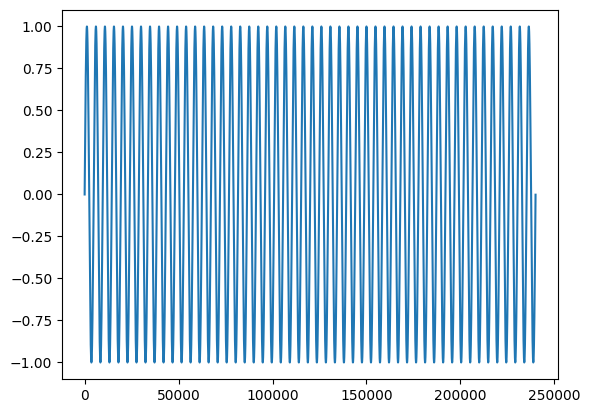

In [6]:
t = np.arange(sample_rate*5)
m = np.sin(2*np.pi*f*t)
print(len(t))
plt.plot(t, m)

In [7]:
input_array = np.array(audio[20*sample_rate:25*sample_rate, 0])
input_array = input_array
print(input_array.shape)
y = (input_array * m).astype(int) 
print(y.dtype)
print(np.max(y))

(240000,)
int32
31672


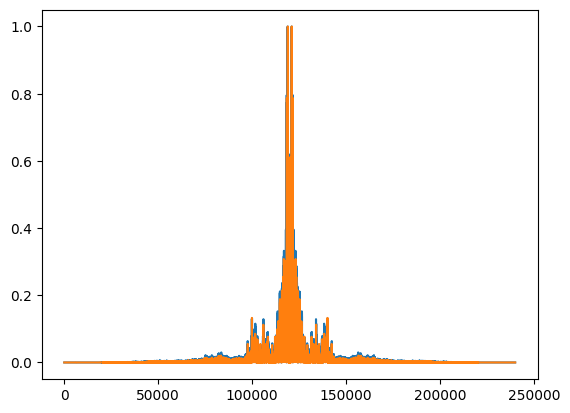

In [8]:
Y_fft = np.abs(fftshift(fft(y)))
I_fft = np.abs(fftshift(fft(input_array)))

plt.plot(Y_fft/np.max(Y_fft))
plt.plot(I_fft/np.max(I_fft))
plt.show()

In [9]:
output_array = scale_array(input_array, y)
print(output_array.dtype)
print(np.max(output_array) / 2**31)
print(np.max(input_array) / 2**15)

int32
0.9999579153954983
0.999969482421875


In [10]:
sample_rate, audio = wavfile.read("Ed Sheeran - Perfect (Official Music Video).wav")
# Create an interface to PortAudio
input_array = np.array(audio[20*sample_rate:25*sample_rate, 0])
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt32,
                channels = 1,
                rate = int(sample_rate*1),
                output = True)
stream.write(y.tobytes()) 
# Close and terminate the stream
stream.stop_stream()
stream.close()
p.terminate()

### Over-Lap and Add (OLP)

In [11]:
sample_rate, audio = wavfile.read("Ed Sheeran - Perfect (Official Music Video).wav")
input_array = np.array(audio[50*sample_rate:60*sample_rate, 0])

#### Shift Down

In [12]:
chunk = 8192
time = (chunk/sample_rate)*1000
print('block_time =',time)
n_chunks = int(len(input_array)/chunk)
print('n_chunks =',n_chunks)
input_array = input_array[:n_chunks*chunk]
overlap_percentage = 0.1
overlap = int(chunk*overlap_percentage)
print('overlap =',overlap)
correct_overlap_percentage = overlap/chunk
print('correcte_overlap_percentage =',correct_overlap_percentage)
window = np.hanning(chunk)
x = input_array.reshape(-1, chunk) * window
print('x_shape =',x.shape)
output_len = (chunk - overlap)*len(x)
print('output_len =',output_len)
y = np.zeros(output_len)
y[0:chunk] += x[0]
for k in range(1,n_chunks-1):
    start = k*chunk - k*overlap
    stop = start + chunk
    y[start:stop] += x[k]
print('contraction=', len(y)/len(input_array))
y = y.astype(int)
y = scale_array(input_array, y)

block_time = 170.66666666666666
n_chunks = 58
overlap = 819
correcte_overlap_percentage = 0.0999755859375
x_shape = (58, 8192)
output_len = 427634
contraction= 0.9000244140625


In [13]:
from scipy.io.wavfile import write

# Example: Generate a simple sinusoidal waveform
duration = 10  # seconds
sample_rating = int(sample_rate*0.9)


# Normalize the audio signal to the range [-32768, 32767] for 16-bit WAV format
#normalized_signal = (audio_signal * 32767).astype(np.int16)

# Specify the output WAV file path
output_file = "pitch_down_olp.wav"

# Write the WAV file
write(output_file, sample_rating, y)

In [14]:
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt32,
                channels = 1,
                rate = int(sample_rate*0.9),
                output = True)
stream.write(y.tobytes()) 
# Close and terminate the stream
stream.stop_stream()
stream.close()
p.terminate()

In [15]:
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16,
                channels = 1,
                rate = int(sample_rate*1),
                output = True)
stream.write(input_array.tobytes()) 
# Close and terminate the stream
stream.stop_stream()
stream.close()
p.terminate()

In [16]:
duration = 10  # seconds


# Normalize the audio signal to the range [-32768, 32767] for 16-bit WAV format
#normalized_signal = (audio_signal * 32767).astype(np.int16)

# Specify the output WAV file path
output_file = "input_olp.wav"

# Write the WAV file
write(output_file, sample_rate, input_array)

#### Shift Up

In [17]:
chunk = 8192
time = (chunk/sample_rate)*1000
print('block_time =',time)
n_chunks = int(len(input_array)/chunk)
print('n_chunks =',n_chunks)
input_array = input_array[:n_chunks*chunk]
print(input_array.shape)
overlap_percentage = 0.1
overlap = int(chunk*overlap_percentage)
print('overlap =',overlap)
correct_overlap_percentage = overlap/chunk
print('correcte_overlap_percentage =',correct_overlap_percentage)
new_chunk = chunk  + overlap
#window = np.ones(new_chunk)
#n_chunks = int(len(input_array)/chunk)
output_len = new_chunk*n_chunks
print('output_len =',output_len)
y = np.array([])
for k in range(0,n_chunks):
    start = k*chunk - k*overlap
    stop = start + new_chunk
    y = np.concatenate((y,input_array[start:stop])) 
print('expansion=', len(y)/len(input_array))
y = y.astype(int)
y = scale_array(input_array, y)

block_time = 170.66666666666666
n_chunks = 58
(475136,)
overlap = 819
correcte_overlap_percentage = 0.0999755859375
output_len = 522638
expansion= 1.0999755859375


In [18]:
# Example: Generate a simple sinusoidal waveform
duration = 10  # seconds
sample_rating = int(sample_rate*1.1)


# Normalize the audio signal to the range [-32768, 32767] for 16-bit WAV format
#normalized_signal = (audio_signal * 32767).astype(np.int16)

# Specify the output WAV file path
output_file = "pitch_up_olp.wav"

# Write the WAV file
write(output_file, sample_rating, y)

In [19]:
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt32,
                channels = 1,
                rate = int(sample_rate*1.1),
                output = True)
stream.write(y.tobytes()) 
# Close and terminate the stream
stream.stop_stream()
stream.close()
p.terminate()